In [1]:
# default_exp explore_data

# module name here

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
!ls raw

competitive-data-science-predict-future-sales.zip  sample_submission.csv
item_categories.csv				   shops.csv
items.csv					   test.csv
sales_train.csv


In [4]:
%%bash
for file in $(ls raw/*.csv); do
  echo "_____________ ${file} _________________"
  echo " - $(wc < ${file})"
  head -n2 ${file} | sed 's/\(.*\)/ > \1/g'
  echo " > ..."
  tail -n2 ${file} | sed 's/\(.*\)/ > \1/g'
  echo
done

_____________ raw/item_categories.csv _________________
 -   85  322 3573
 > item_category_name,item_category_id
 > PC - Гарнитуры/Наушники,0
 > ...
 > Чистые носители (штучные),82
 > Элементы питания,83

_____________ raw/items.csv _________________
 -   22171  132636 1568417
 > item_name,item_id,item_category_id
 > ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D,0,40
 > ...
 > Яйцо для Little Inu,22168,62
 > Яйцо дракона (Игра престолов),22169,69

_____________ raw/sales_train.csv _________________
 -  2935850  2935850 94603866
 > date,date_block_num,shop_id,item_id,item_price,item_cnt_day
 > 02.01.2013,0,59,22154,999.0,1.0
 > ...
 > 22.10.2015,33,25,7440,299.0,1.0
 > 03.10.2015,33,25,7460,299.0,1.0

_____________ raw/sample_submission.csv _________________
 -  214201  214201 2245108
 > ID,item_cnt_month
 > 0,0.5
 > ...
 > 214198,0.5
 > 214199,0.5

_____________ raw/shops.csv _________________
 -   61  210 2977
 > shop_name,shop_id
 > "!Якутск Орджоникидзе, 56 фран",0
 > ...
 > "Якутск ТЦ 

# sales_train

In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
sales_train = pd.read_csv('raw/sales_train.csv')

In [7]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

<AxesSubplot:>

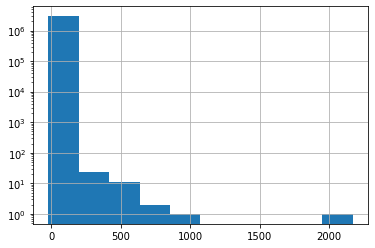

In [8]:
sales_train['item_cnt_day'].hist(log=True)

In [9]:
# Daily historical data from January 2013 to October 2015 - looks like dec entries are there :/
sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_train['date'].agg(['min', 'max'])

min   2013-01-01
max   2015-12-10
Name: date, dtype: datetime64[ns]

In [118]:
sales_train.query('date > "2015-10-30"')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2323430,2015-11-01,24,27,20404,2399.00,1.0
2323439,2015-11-01,24,27,20096,239.36,1.0
2323465,2015-12-01,24,27,20611,2249.00,1.0
2323516,2015-12-01,24,27,19571,199.00,1.0
2323536,2015-11-01,24,27,19134,499.00,1.0
...,...,...,...,...,...,...
2935807,2015-11-10,33,25,7624,250.00,1.0
2935818,2015-10-31,33,25,7780,198.00,1.0
2935830,2015-11-10,33,25,7286,299.00,1.0
2935840,2015-10-31,33,25,7409,299.00,1.0


In [10]:
# Note that the list of shops and products slightly changes every month.
# Creating a robust model that can handle such situations is part of the challenge.
sales_train['item_id'].value_counts()

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
         ...  
593          1
13866        1
16574        1
20668        1
0            1
Name: item_id, Length: 21807, dtype: int64

In [24]:
train_counts_by_item_id = sales_train['item_id'].value_counts()
train_counts_by_item_id

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
         ...  
593          1
13866        1
16574        1
20668        1
0            1
Name: item_id, Length: 21807, dtype: int64

In [15]:
sales_test = pd.read_csv('raw/test.csv')

In [21]:
# So there seem to be less items in test vs train. There seem to be 42 shops
test_counts_by_id = sales_test['item_id'].value_counts()
test_counts_by_id

2047     42
19744    42
15406    42
13359    42
3240     42
         ..
21086    42
21214    42
17244    42
21342    42
2049     42
Name: item_id, Length: 5100, dtype: int64

In [44]:
records_by_item = pd.DataFrame(test_counts_by_id).join(
    pd.DataFrame(train_counts_by_item_id), 
    lsuffix='_test', rsuffix='_trn'
).rename({'item_id_test': 'cnt_test',
         'item_id_trn': 'cnt_trn'}, axis=1)
records_by_item

,cnt_test,cnt_trn
2047,42,752.0
19744,42,51.0
15406,42,71.0
13359,42,78.0
3240,42,19.0
...,...,...
21086,42,27.0
21214,42,NaN
17244,42,48.0
21342,42,14.0


In [51]:
# some of the items never appeared in train
nan = np.nan
records_by_item.query('cnt_trn != cnt_trn')

,cnt_test,cnt_trn
1193,42,NaN
13231,42,NaN
1577,42,NaN
12591,42,NaN
14765,42,NaN
...,...,...
3538,42,NaN
4310,42,NaN
13394,42,NaN
6743,42,NaN


In [53]:
items = pd.read_csv('raw/items.csv')
items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


In [58]:
# Some of the categories in test were not in train
(records_by_item
    .merge(items, right_on='item_id', left_index=True)
    .fillna(0)
    .groupby('item_category_id')
    .agg({'cnt_test': 'sum', 'cnt_trn': 'sum'})
    .query('cnt_trn == 0')
)

,cnt_test,cnt_trn
item_category_id,,
0,42,0.0
27,42,0.0


In [83]:
items.query('item_category_id == 0 or item_category_id == 27').count()

item_name           12
item_id             12
item_category_id    12
dtype: int64

In [70]:
records_by_item.loc[21214]

cnt_test    42.0
cnt_trn      NaN
Name: 21214, dtype: float64

In [85]:
no_train_cats = (sales_test.merge(items, on='item_id')
 .query('item_category_id == 0 or item_category_id == 27')
)
no_train_cats.head(1)

,ID,shop_id,item_id,item_name,item_category_id
147588,3514,5,5441,PC: Гарнитура HyperX Cloud Core игровая стерео...,0


In [81]:
records_by_item.loc[5441]

cnt_test    42.0
cnt_trn      NaN
Name: 5441, dtype: float64

In [101]:
shops = pd.read_csv('raw/shops.csv')
categories = pd.read_csv('raw/item_categories.csv')

In [105]:
# fits into memory regardless and speeds up me building queries later
sales_train_joined = (sales_train
    .merge(items, on='item_id')
    .merge(shops, on='shop_id')
    .merge(categories, on='item_category_id')
)
sales_train_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   item_name           object        
 7   item_category_id    int64         
 8   shop_name           object        
 9   item_category_name  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 246.4+ MB


In [104]:
sales_test_joined = (sales_test
    .merge(items, on='item_id')
    .merge(shops, on='shop_id')
    .merge(categories, on='item_category_id')
)

In [112]:
sales_train_last_by_item = (sales_train_joined
    .groupby('item_id', as_index=False)
    .agg({'date': 'max'})
)
sales_train_last_by_item.head(1)

,item_id,date
0,0,2014-01-09


<AxesSubplot:>

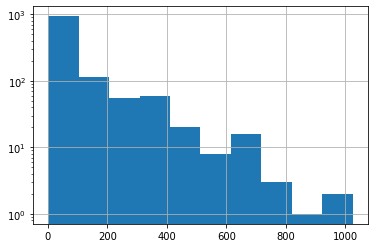

In [141]:
days_before = (pd.to_datetime('2015-11-01') - sales_test
    .merge(sales_train_last_by_item, on='item_id', how='left')
    .groupby('item_id', as_index=False)
    .agg({'date': 'max'})['date']
).dt.days

days_before[days_before > 0].hist(log=True)

<AxesSubplot:>

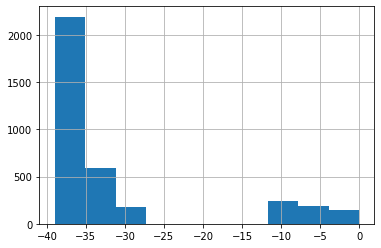

In [146]:
# this provides us with info about the future :/ can be used for CV?
days_before[days_before <= 0].hist()

In [61]:
# Q4: is there any skew in terms of shops? items? categories? specializations maybe
# Q5: anything cool we can extract out of item / category / shop names?

In [77]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62
